In [2]:
import py_wgpu_fdm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

### Geometry parameters

In [3]:
d = 0.5e-2
D = 1.0e-1 
L = 1.2
node_count = 960
turns = 1024

r = (D + d)/2
p = L / (turns * 2 * np.pi)

kappa = r / (r**2 + p**2)
tau = p / (r**2 + p**2)

S = 2.0 * np.pi * turns * np.sqrt(r**2 + p**2)

ds = S / ( node_count - 1 )
dx = L / ( node_count - 1 )
dx2 = dx * dx


print(f"Curvature κ: {kappa:.3e} 1/m")
print(f"Torsion τ: {tau:.3e} 1/m")
print(f"Wire length S: {S:.3f} m")
print(f"Helix delta: {ds:.3f} m")
print(f"Core delta: {dx:.3f} m")

Curvature κ: 1.905e+01 1/m
Torsion τ: 6.767e-02 1/m
Wire length S: 337.786 m
Helix delta: 0.352 m
Core delta: 0.001 m


### Material parameters

In [4]:
def winding_properties(d, E, G, rho, kappa):
    """
    d      : diameter
    E      : Young's modulus
    G      : shear modulus
    rho    : density
    kappa  : curvature (1/R)
    """

    r = d / 2

    # Cross-section properties for a solid circular rod
    A  = np.pi * r**2
    I1 = I2 = (np.pi * r**4) / 4      # bending
    IT = (np.pi * r**4) / 2           # torsion

    # Shear stiffness parameters (straight-beam)
    k1 = np.sqrt(I1 / A)
    k2 = np.sqrt(I2 / A)
    kT = np.sqrt(IT / A)

    # Straight-beam rigidities
    beta1 = E * I1
    beta2 = E * I2
    betaT = G * IT
    sigma1 = G * A
    sigma2 = G * A
    sigma_p = E * A

    # ----------------------------------------------------------
    # Effective rigidities for a curved beam using curvature κ
    # ----------------------------------------------------------
    beta1_eff = beta1 / (1 + (kappa**2) * I1 / A)
    beta2_eff = beta2 / (1 + (kappa**2) * I2 / A)
    betaT_eff = betaT / (1 + (kappa**2) * IT / A)

    # Effective axial rigidity (optional)
    sigma_p_eff = sigma_p / (1 + (kappa**2) * A / I1)

    mass_per_length = rho * A
    return {
        'mu': mass_per_length,
        'k': [k1, k2, kT],
        'beta': [beta1, beta2, betaT],
        'sigma': [sigma1, sigma2, sigma_p]
    }

def core_properties(D, T, rho):
        r = D / 2
        A = np.pi * r**2
        mass_per_length = rho * A
        c2 = T / mass_per_length
    
        return {
        'c2': c2,
        'mu': mass_per_length,
    }

In [5]:
loss = 0.9999999990
rho = 8960
rho_core = 8700
E=115e9
G=45e9
F_T=800

coil_props = winding_properties(d, E, G, rho, kappa)
core_props = core_properties(D, F_T, rho_core)

print("=== Winding Properties ===")
print(f"Mass per length: {coil_props['mu']:.3e} kg/m")
print(f"k (m): [k1={coil_props['k'][0]:.3e}, k2={coil_props['k'][1]:.3e}, kT={coil_props['k'][2]:.3e}]")
print(f"Beta (N·m²): [β1={coil_props['beta'][0]:.3e}, β2={coil_props['beta'][1]:.3e}, βT={coil_props['beta'][2]:.3e}]")
print(f"Sigma (Pa): [σ1={coil_props['sigma'][0]:.3e}, σ2={coil_props['sigma'][1]:.3e}, σp={coil_props['sigma'][2]:.3e}]")

print("\n=== Core Properties ===")
print(f"Mass per length: {core_props['mu']:.3e} kg/m")
print(f"Wave speed squared (c²): {core_props['c2']:.3e} m²/s²")

=== Winding Properties ===
Mass per length: 1.759e-01 kg/m
k (m): [k1=1.250e-03, k2=1.250e-03, kT=1.768e-03]
Beta (N·m²): [β1=3.528e+00, β2=3.528e+00, βT=2.761e+00]
Sigma (Pa): [σ1=8.836e+05, σ2=8.836e+05, σp=2.258e+06]

=== Core Properties ===
Mass per length: 6.833e+01 kg/m
Wave speed squared (c²): 1.171e+01 m²/s²


### Instantiate CPU side node buffer

In [9]:

# Create initial node data in local (u,v,w) helical frame
nodes = []
for i in range(node_count):
    position = [0.0, 0.0, 0.0]  
    velocity = [0.0, 0.0, 0.0]
    angle = [0.0, 0.0, 0.0]
    angular_velocity = [0.0, 0.0, 0.0]
    
    nodes.append([position, velocity, angle, angular_velocity])



### Time-stepping & Sampling parameters
`safe_int` is defined to throw an error if the parameters do not actually yield integers.
**TODO:** floating point imprecision can cause safe parameters to throw an error.

In [10]:

def safe_int(n):
    if not isinstance(n, int) and not (isinstance(n, float) and n.is_integer()):
        raise TypeError(f"Expected integer!")
    n = int(n)
    return n

In [11]:
dt = 1.0e-7
T = 0.3
SAMPLE_RATE = 50000
chunk_size = 1000

NUM_STEPS = T / dt
print(NUM_STEPS)
NUM_FRAMES = T * SAMPLE_RATE
print(NUM_FRAMES)
OS_FACTOR = safe_int(NUM_STEPS / NUM_FRAMES)
invocations = safe_int(NUM_STEPS / ( chunk_size * OS_FACTOR))

print(f'Target sample rate demands {invocations} invocations at an oversampling factor of {OS_FACTOR}')

3000000.0
15000.0
Target sample rate demands 15 invocations at an oversampling factor of 200


### Set up simulation
The rust-side function signature is

```rust
fn new(
    nodes: Vec<[[f32; 3]; 4]>,
    oversampling_factor: usize,
    dt: f32,
    two_ds_inv: f32,
    loss: f32,
    tau: f32,
    kappa: f32,
    m_inv: f32,
    dxf_t: f32,
    beta: [f32; 3],
    dx2_inv: f32,
    sigma: [f32; 3],
    chunk_size: u32,
    muk2_inv: [f32; 3],
) -> PyResult<Self>
```
Arguments must be provided in the correct order! 


In [12]:
ori_frames = []

n_frames = chunk_size * invocations

print("Setting up simulation instance")

# Setup simulation object
sim = py_wgpu_fdm.Simulation(
    nodes,
    OS_FACTOR,
    dt,
    1/(2*ds),
    loss,
    tau,
    kappa,
    1/(coil_props['mu'] * ds + core_props['mu'] * dx),
    dx * F_T,
    coil_props['beta'],
    1/dx2,
    coil_props['sigma'],
    chunk_size,
    [1 /( coil_props['mu'] * k**2 ) for k in coil_props['k']],
)

print(f'Running {NUM_STEPS} steps, which is {T} seconds. Generating {NUM_FRAMES} output samples.') 


Setting up simulation instance
Running 3000000.0 steps, which is 0.3 seconds. Generating 15000.0 output samples.


### Initialize the starting state
This is done by injecting a small external force at Node $200$ (currently hardcoded).
The rust code has the function signature

```rust
fn initialize(&mut self, force: f32, steps: usize) 
    -> PyResult<Vec<[[f32; 3]; 8]>> 

```
and calling this function succesfully will return a frame of the initial state. The amount of initial steps can be chose quite liberally since there are no memory transfers and thus the GPU can operate fully asynchronously!

In [13]:
external_force = 10000
init_steps = 100



initial_state = sim.initialize(external_force, init_steps)

print(f"Initial condition reached after {init_steps * dt} seconds.")

Calling GPU binding
Calling init!
Initial condition reached after 9.999999999999999e-06 seconds.
Transferring buffer with size 122880000


We can plot the initial condition to get a view of the displacements.

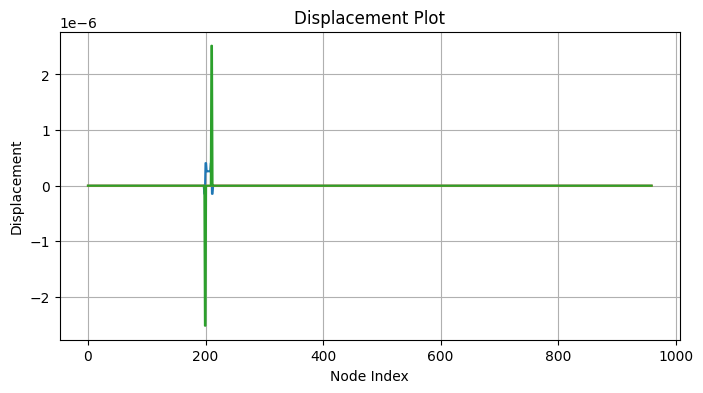

In [14]:
u_displacement = [ n[0][0] for n in initial_state ]
v_displacement = [ n[0][1] for n in initial_state ]
w_displacement = [ n[0][2] for n in initial_state ]


plt.figure(figsize=(8,4))
plt.plot(u_displacement)
plt.plot(v_displacement)
plt.plot(w_displacement)
plt.xlabel('Node Index')
plt.ylabel('Displacement')
plt.title('Displacement Plot')
plt.grid(True)
plt.show()

In [15]:
print("Node 200 is at:")
initial_state[200]

Node 200 is at:


[[4.0624098573971423e-07, -3.146334748294066e-08, -2.5166102659568423e-06],
 [0.41142863035202026, -0.005320885684341192, -0.6164113879203796],
 [-0.00034643179969862103, 1.9963167687819805e-06, -4.902422915620264e-06],
 [-31.342458724975586, 9.88904857635498, -1.7193541526794434],
 [18.94756317138672, 2.226191997528076, -54.741943359375],
 [0.011860951781272888, 0.0017733818385750055, -0.00024411117192357779],
 [-7455.7138671875, 79.17201232910156, -2985.56640625],
 [-0.33275100588798523, 0.019456222653388977, 1.5707838535308838]]

### Run the model
Depending on the chosen parameters, this can take quite a bit.
While the calculations themselves are fast, the memory transfers are most likely bottlenecking the whole simulation. This is helped by tranferring the results in chunks (i.e. buffering) however since large amounts of data have to be transferred out ($4 \cdot 3 \cdot 8 \cdot N \cdot T \cdot F_S$ bytes) this is always going to be taxing.
It is the cost that one incurrs for obtaining a full view of the simulation at each timestep.

**N.B.** Rust will print to `stdout` every time a memory transfer is started.
While the notebook may be slow on printing this message, it should output accurately to console. The best indicator however is probably watching GPU resource usage.

In [ ]:
print(f'Running {invocations} invocations calculating {NUM_STEPS} steps, which is {T} seconds. Generating {NUM_FRAMES} output samples.') 


for i in range(invocations):
    sim.compute()
    frames = sim.save()
    for frame in frames:
        ori_frames.append(frame)

In [13]:
frames[8][200]

[[1.7306785338178088e-08, 1.756472300940004e-08, 1.191328280469861e-07],
 [-0.02523074671626091, 5.2671377488877624e-05, 0.006780384574085474],
 [9.108818630920723e-06, 3.295769488431688e-07, 1.5393723629131273e-07],
 [-0.8473128080368042, -0.48797357082366943, 0.003967613913118839],
 [0.7768223881721497, 1.2562661170959473, -13.337571144104004],
 [-0.0007499895873479545, 0.00016829688684083521, -0.0012414605589583516],
 [-1032.1878662109375, 6.90902853012085, -9.996414184570312],
 [-0.0045981816947460175, 0.01854446530342102, 0.15380702912807465]]

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assume frames is already defined as:
# frames[time_step][node_index][0][0] -> displacement value

frames = [ f for i,f in enumerate(ori_frames) if i % 10 == 0 ]


# Extract number of time steps and nodes
num_frames = len(frames)
num_nodes = len(frames[0])

# Build coordinate grids
time_steps = np.arange(num_frames)
node_indices = np.arange(num_nodes)
T, N = np.meshgrid(time_steps, node_indices, indexing='ij')

# Extract displacement values into a 2D array (time × nodes)
displacements = np.array([[frame[node][0][0] for node in range(num_nodes)] for frame in frames])

# Create 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(N, T, displacements, cmap='viridis', edgecolor='none')

# Axis labels
ax.set_xlabel('Node Number')
ax.set_ylabel('Time Step')
ax.set_zlabel('Displacement')

ax.set_title('3D Displacement of Nodes Over Time')

plt.show()
print(f'Frame count: {num_frames}')


KeyboardInterrupt



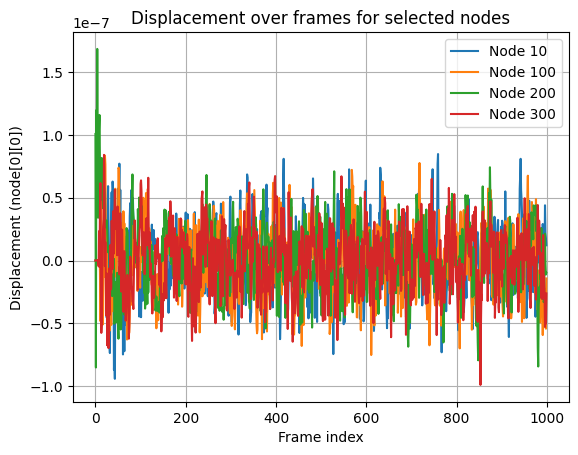

In [15]:
import matplotlib.pyplot as plt




indices = [ 10, 100, 200, 300 ]

# Extract displacements
for i in indices:
    displacements = [frame[i][0][0] for frame in frames]
    plt.plot(range(len(frames)), displacements, label=f'Node {i}')

plt.xlabel('Frame index')
plt.ylabel('Displacement (node[0][0])')
plt.title('Displacement over frames for selected nodes')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
import numpy as np
import sounddevice as sd

def play_float_array(arr, duration=None):
    """
    Play a 1D numpy float array as audio.
    
    Parameters:
        arr : np.ndarray
            Float array with arbitrary range.
        duration : float or None
            Duration in seconds. If None, defaults to len(arr)/44100.
    """
    arr = np.asarray(arr, dtype=float)
    
    # Normalize to [-1, 1]
    max_val = np.max(np.abs(arr))
    if max_val > 0:
        arr = arr / max_val
    
    # Set sample rate to match duration
    if duration is None:
        samplerate = 50000  # default
    else:
        samplerate = int(len(arr) / duration)
    
    # Convert to 16-bit PCM
    audio = np.int16(arr * 32767)
    
    # Play audio
    sd.play(audio, samplerate)
    sd.wait()

# Example usage:
# Generate a 1-second sine wave at 440 Hz
fs = 44100
t = np.linspace(0, 1, fs, endpoint=False)
signal = np.sin(2 * np.pi * 440 * t)

#play_float_array(signal)

node_disps = [ f[100][0] for f in ori_frames ]

from scipy.signal import resample_poly
def downsample(audio, sr_in=1_000_000, sr_out=44_100):
    """
    Downsample an audio signal from sr_in to sr_out using polyphase filtering.
    
    audio : np.ndarray
        Input 1D signal.
    sr_in : int
        Original sample rate.
    sr_out : int
        Target sample rate.
    """
    # Compute integer up/down factors
    # You can also just pass sr_out, sr_in directly; SciPy handles ratios
    y = resample_poly(audio, sr_out, sr_in)
    return y

smpls = downsample(node_disps, sr_in=50000)
distances = np.linalg.norm(smpls, axis=1)

play_float_array(distances)
#smpls
len(ori_frames)


10000

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
def frenet_to_cartesian(frames, alpha_deg):

    # Transformation matrix R
    R = np.array([
        [1, 0, 0],
        [0, np.cos(alpha), -np.sin(alpha)],
        [0, np.sin(alpha),  np.cos(alpha)]
    ])
    # Apply transformation to each frame
    cart_frames = frames @ R.T
    return cart_frames


def render_movie(displacements, ds=1.0, framerate=30, filename="3d_string.mp4"):
    """
    Animate a 3D string given node displacements.

    displacements: np.array of shape (num_frames, num_nodes, 3)
    ds: spacing along the string in z-direction
    """
    num_frames, num_nodes, _ = displacements.shape

    # Precompute the base z-coordinates along the string
    z_base = np.linspace(0, L, num_nodes)  # Evenly spaced along the length L
    base_coords = np.zeros((num_nodes, 3))
    base_coords[:, 2] = z_base  # (x=0, y=0, z=z_base)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    line, = ax.plot([], [], [], 'o-', lw=1)

    # Compute limits
    all_coords = base_coords + displacements
    ax.set_xlim(np.min(all_coords[:,:,0]), np.max(all_coords[:,:,0]))
    ax.set_ylim(np.min(all_coords[:,:,1]), np.max(all_coords[:,:,1]))
    ax.set_zlim(np.min(all_coords[:,:,2]), np.max(all_coords[:,:,2]))

    def init():
        line.set_data([], [])
        line.set_3d_properties([])
        return line,

    def update(frame_idx):
        coords = base_coords + displacements[frame_idx]
        x = coords[:,0]
        y = coords[:,1]
        z = coords[:,2]
        line.set_data(x, y)
        line.set_3d_properties(z)
        return line,

    interval = 1000 / framerate
    ani = FuncAnimation(fig, update, frames=num_frames, init_func=init, blit=True, interval=interval)

    # Save animation
    writer = FFMpegWriter(fps=framerate)
    ani.save(filename, writer=writer)

    plt.show()
    return ani


    
alpha = np.arctan(p/r)
displacements = np.array([[frame[node][0] for node in range(num_nodes)] for frame in ori_frames])

cart_frames = frenet_to_cartesian(displacements, alpha)
ani = render_movie(cart_frames, framerate=25)


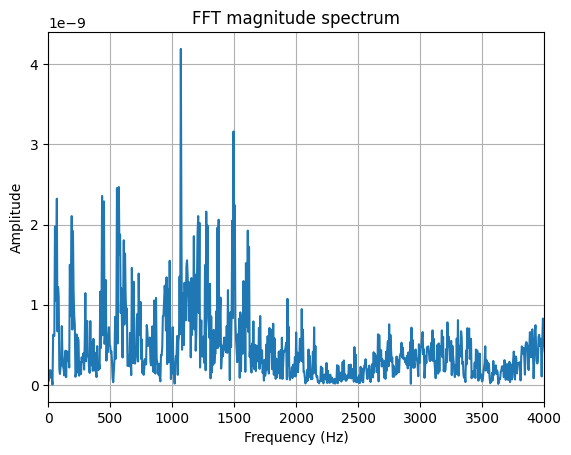

In [21]:
# --- FFT ---
N = len(ori_frames)
X = np.fft.fft([f[100][0][1] for f in ori_frames ])
freqs = np.fft.fftfreq(N, d=1/50000)

# Only keep the positive frequencies
idx = np.where(freqs >= 0)
freqs_pos = freqs[idx]
X_pos = X[idx]

# Magnitude spectrum
mag = np.abs(X_pos) * (2.0 / N)   # scale for single-sided spectrum
phase = np.angle(X_pos) * ( 0.0005 / N)

# --- Plot ---
plt.figure()
plt.plot(freqs_pos, mag)
plt.title("FFT magnitude spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.xlim(0, 4000)
plt.show()